**Imports**

In [1]:
from google.colab import drive
import os

drive.mount('/content/drive/')
os.getcwd()

path = '/content/drive/My Drive/github_projects/SUL/classification/titanic/'
os.chdir(path)
os.listdir(path)


for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Mounted at /content/drive/
/content/drive/My Drive/github_projects/SUL/classification/titanic/train.csv
/content/drive/My Drive/github_projects/SUL/classification/titanic/test.csv
/content/drive/My Drive/github_projects/SUL/classification/titanic/gender_submission.csv


In [2]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, QuantileTransformer,RobustScaler
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
warnings.filterwarnings("ignore")


%matplotlib inline

* Predefined Functions

In [3]:
def num_cat_split(df):
    '''returns list of numerical and categorical columns'''
    
    num_col = list(df.select_dtypes(include=['number']).columns)
    cat_col = list(set(df.columns) - set(num_col))

    print(f"Numerical columns : \n{num_col}")
    print("")
    print(f"Categorical columns :\n {cat_col}")
    
    return num_col, cat_col


def cabin_letter(x):
    '''returns cabin letter or nan'''
    if isinstance(x, str):
        return x[0]
    else:
        return str(np.nan)
    
def featuring(DF):
    DF.drop(['Name','PassengerId', 'Ticket'], axis=1, inplace=True)
    DF['Cabin'] = DF['Cabin'].apply(cabin_letter)
    DF['Embarked'] = DF['Embarked'].str.upper()
    return DF.copy()

**1. Load Data**

In [4]:
DF = pd.read_csv('train.csv')
DF

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


**2. N/A Columns**

In [5]:
p = 0.7 # columns with more than 30 n/a rows 
df_rows = DF.shape[0]
na_freq = DF.isna().sum().sort_values(ascending=False) / df_rows
na_freq = na_freq[na_freq > 0.3]

na_freq

Cabin    0.771044
dtype: float64

In [6]:
na_columns = na_freq.index

In [7]:
na_num_col, na_cat_col = num_cat_split(DF[na_columns])

Numerical columns : 
[]

Categorical columns :
 ['Cabin']


**3. Numerical Columns**

In [8]:
num_col , _ = num_cat_split(DF)

Numerical columns : 
['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

Categorical columns :
 ['Embarked', 'Cabin', 'Name', 'Sex', 'Ticket']


[]

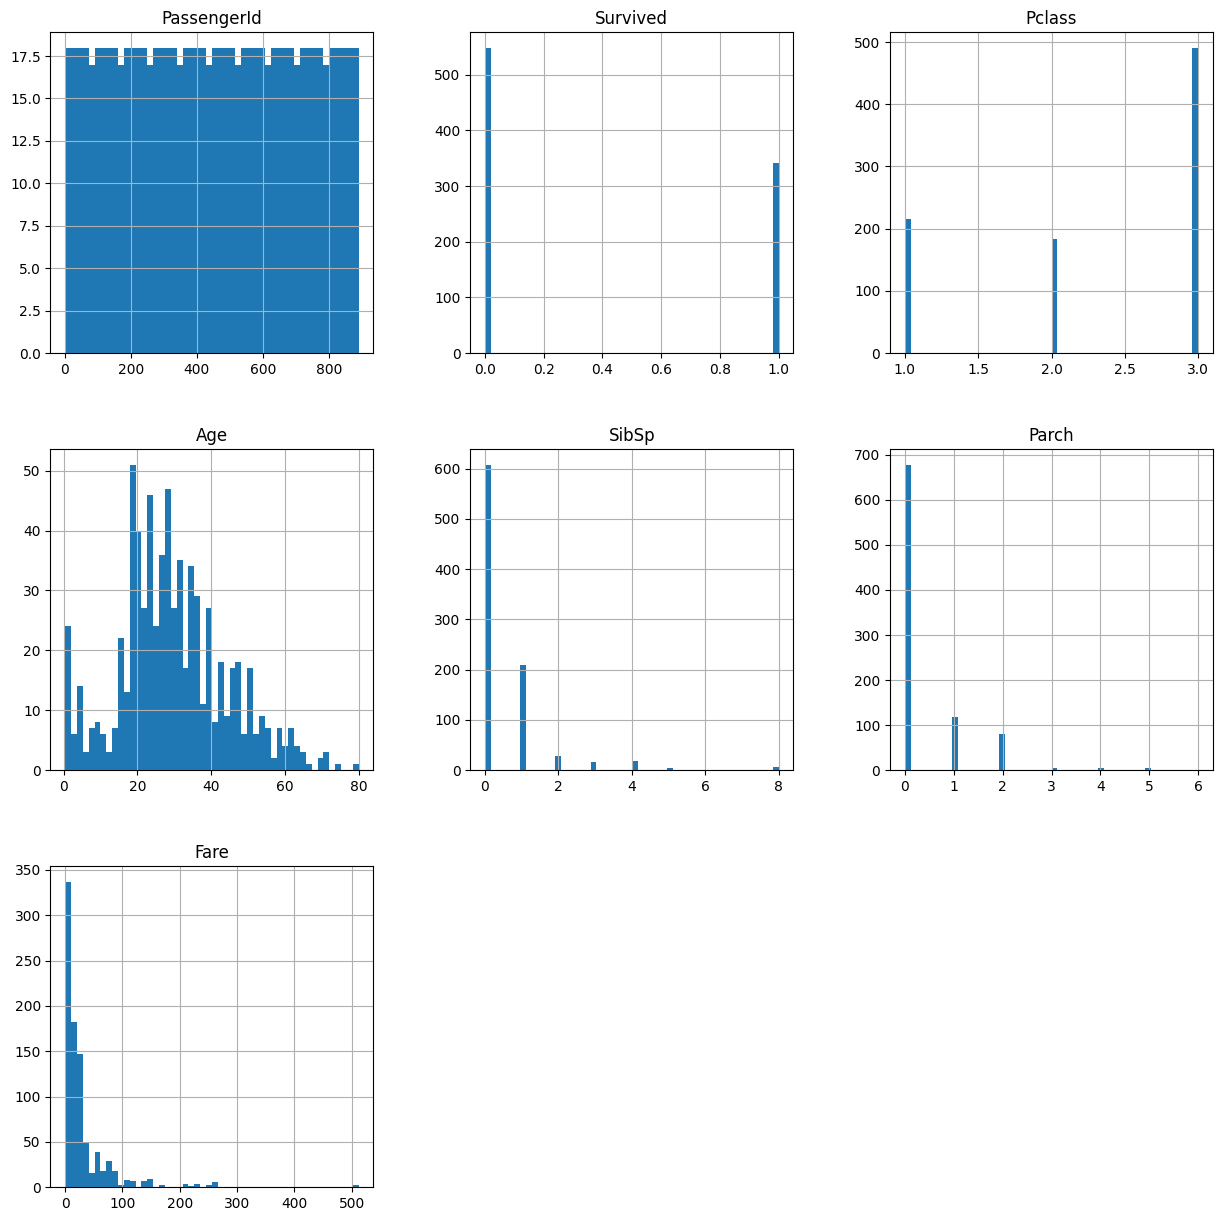

In [9]:
DF[num_col].hist(bins=50,figsize=(15,15))
plt.plot()

**4. Categorical Columns**

In [10]:
_ , cat_col = num_cat_split(DF)

Numerical columns : 
['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

Categorical columns :
 ['Embarked', 'Cabin', 'Name', 'Sex', 'Ticket']


**5. Featuring**

In [11]:
DF = featuring(DF)
DF

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,nan,S
1,1,1,female,38.0,1,0,71.2833,C,C
2,1,3,female,26.0,0,0,7.9250,nan,S
3,1,1,female,35.0,1,0,53.1000,C,S
4,0,3,male,35.0,0,0,8.0500,nan,S
...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,nan,S
887,1,1,female,19.0,0,0,30.0000,B,S
888,0,3,female,NaN,1,2,23.4500,nan,S
889,1,1,male,26.0,0,0,30.0000,C,C


**6. Train test split**

In [12]:
X = DF.drop(['Survived'], axis=1).copy()
y = DF.Survived

# sample = RandomUnderSampler(sampling_strategy=1)
sample = RandomOverSampler(sampling_strategy='minority')

X_new, y_new = sample.fit_resample(X, y)

In [13]:
X_train, X_valid, y_train, y_valid = train_test_split(X_new, y_new, test_size=.2, random_state=77, stratify=y_new)

<Axes: ylabel='Survived'>

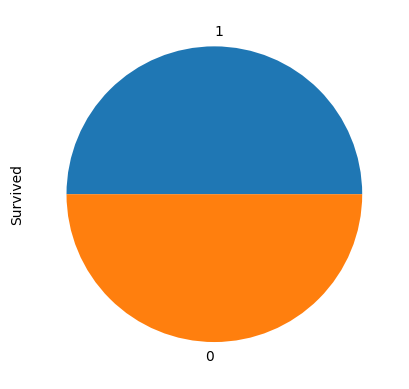

In [14]:
y_train.value_counts().plot.pie()

**7. Preprocessing**

In [15]:
num_col, cat_col = num_cat_split(X)

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('numerical_imputer', SimpleImputer(strategy='median')),
    ('quantile', QuantileTransformer(n_quantiles=100, output_distribution='normal')),
    # ('robust', RobustScaler((5,95))),
    ('scaler', StandardScaler()),
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('categorical_imputer', SimpleImputer(fill_value='NA', strategy='constant')),
    ('onehot_encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num1', numerical_transformer, num_col),
        ('cat', categorical_transformer, cat_col)
    ])

Numerical columns : 
['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

Categorical columns :
 ['Embarked', 'Sex', 'Cabin']


In [16]:
X_train__transformed = preprocessor.fit_transform(X_train)
# X_train__transformed

**8. PyTorch Model**

In [17]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(NeuralNet, self).__init__()
        self.input = nn.Linear(input_size, hidden_size)
        self.h1 = nn.Linear(hidden_size, hidden_size // 2)
        self.h2 = nn.Linear(hidden_size // 2, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.drop = nn.Dropout(0.3)

        
    def forward(self, x):
        '''Forward propagation'''
        out = self.input(x)
#         out = self.drop(out)
        out = self.relu(self.h1(out))
#         out = self.drop(out)
        out = self.sigmoid(self.h2(out))
        return out

**8.1 Model**

In [18]:
input_size = X_train__transformed.shape[1]

model = NeuralNet(input_size, input_size)

**8.2 Loss Function and Optimizer**

In [19]:
criterion = nn.BCELoss() #Binary Cross Entropy
# optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, nesterov=True, momentum=0.8)

**8.3 Train the Model**

In [20]:
epochs = 70
batch_size = 8

# Numpy to tensor
train_sample_y = torch.from_numpy(y_train.values).float().view(-1,1)
train_sample_X = torch.from_numpy(X_train__transformed).float()

train_ds = torch.utils.data.TensorDataset(train_sample_X, train_sample_y)
train_loader = torch.utils.data.DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True)

In [21]:
train_sample_X.shape

torch.Size([878, 19])

In [22]:
total_steps = len(train_loader)

for epoch in range(epochs):
    total_loss = 0
    model.train()
    for i, (features, labels) in enumerate(train_loader):
        
        optimizer.zero_grad()
        outputs = model(features) #forward propagation
        
        loss = criterion(outputs, labels) 
        
        # backward propagation
        loss.backward()
        optimizer.step()
        total_loss += loss.data.item()
    print("Epoch: {}, BCELoss: {}".format(epoch, total_loss / len(train_loader)))

Epoch: 0, BCELoss: 0.6892770360816609
Epoch: 1, BCELoss: 0.6670559558001432
Epoch: 2, BCELoss: 0.6075140888040717
Epoch: 3, BCELoss: 0.5277268745682456
Epoch: 4, BCELoss: 0.47682103731415487
Epoch: 5, BCELoss: 0.46617073782465673
Epoch: 6, BCELoss: 0.46160523742437365
Epoch: 7, BCELoss: 0.45873417908495123
Epoch: 8, BCELoss: 0.4556864334101027
Epoch: 9, BCELoss: 0.4524880048903552
Epoch: 10, BCELoss: 0.45148353563113647
Epoch: 11, BCELoss: 0.4506162628531456
Epoch: 12, BCELoss: 0.4462950445034287
Epoch: 13, BCELoss: 0.4445781714536927
Epoch: 14, BCELoss: 0.4450353210622614
Epoch: 15, BCELoss: 0.439085079729557
Epoch: 16, BCELoss: 0.4366916595534845
Epoch: 17, BCELoss: 0.4354364072057334
Epoch: 18, BCELoss: 0.4303473948755048
Epoch: 19, BCELoss: 0.4314976910298521
Epoch: 20, BCELoss: 0.43014804883436725
Epoch: 21, BCELoss: 0.42792700346220625
Epoch: 22, BCELoss: 0.426108442382379
Epoch: 23, BCELoss: 0.4225000923330134
Epoch: 24, BCELoss: 0.4244385138831355
Epoch: 25, BCELoss: 0.42037044

In [24]:
X_valid__transformed = preprocessor.transform(X_valid).astype('float32')

#predictions
# model.eval()
preds = model(torch.from_numpy(X_valid__transformed)).squeeze().detach().numpy().round()

# model performence
print(classification_report(y_valid, preds))

              precision    recall  f1-score   support

           0       0.82      0.85      0.83       110
           1       0.84      0.81      0.82       110

    accuracy                           0.83       220
   macro avg       0.83      0.83      0.83       220
weighted avg       0.83      0.83      0.83       220



In [25]:
X_test = pd.read_csv('test.csv')
Id = X_test['PassengerId']
X_test = featuring(X_test)
X_test = preprocessor.transform(X_test).astype('float32')
preds_test = model(torch.from_numpy(X_test)).squeeze().detach().numpy().round().astype('int')
# Save test predictions to file
output = pd.DataFrame({'PassengerId': Id,
                       'Survived': preds_test})
output

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


**Visualize the Pytorch Model**

In [26]:
torch.onnx.export(model, X_test, 'titanic_classification.onnx', input_names=["features"], output_names=["logits"])

============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



RuntimeError: ignored